# MovieLens 1M Collaborative Genre Tagging
**To do**:
  - try out [this implementation](https://www.onceupondata.com/2019/02/10/nn-collaborative-filtering/) of baseline features. 
  - create object classes for models
  - implement TF 2.0 data classes
  - [paperswithcode link](https://paperswithcode.com/sota/collaborative-filtering-on-movielens-100k)
  - [ML 100k state of the art paper](https://arxiv.org/pdf/1706.02263v2.pdf) (RMSE=0.905): details their evaluation method
  
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/James-Leslie/deep-collaborative-filtering/blob/master/tf-movielens1m.ipynb)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Load rating data

In [2]:
# path = 'https://raw.githubusercontent.com/James-Leslie/deep-collaborative-filtering/master/data/ml-1m/'  # access from anywhere
path = 'data/ml-1m/'  # if the files are local
df = pd.read_csv(path+'ratings.csv', usecols=['userId','movieId','rating'])

In [3]:
df.head()

,userId,movieId,rating
0,0,0,5
1,0,1,3
2,0,2,3
3,0,3,4
4,0,4,5


In [4]:
df.shape

(1000209, 3)

In [5]:
print('Number of users:', df.userId.nunique())
print('Number of items:', df.movieId.nunique())
print("Min item rating:", df.rating.min())
print("Max item rating:", df.rating.max())
print("Mean item rating:", df.rating.mean())

Number of users: 6040
Number of items: 3706
Min item rating: 1
Max item rating: 5
Mean item rating: 3.581564453029317


## Load movie metadata
  - remove 10% as holdout test set

In [6]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,One Flew Over the Cuckoo's Nest (1975),0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,James and the Giant Peach (1996),0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2,My Fair Lady (1964),0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,3,Erin Brockovich (2000),0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,4,"Bug's Life, A (1998)",0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
from sklearn.model_selection import train_test_split

In [8]:
movies, movies_holdout = train_test_split(movies, test_size=.1, random_state=42)

---
# Create baseline features
For each user, calculate average user bias - the average difference between the user's rating and the movie's average rating:

$$b_{u} = \dfrac{\sum_{j=1}^{n_u} (r_{uj} - \mu_i)}{n_u}$$

For each item, calculate the difference between its average rating and the average rating of all movies:

$$b_{i} = \dfrac{\sum_{k=1}^{n_i} (r_{ki})}{n_i} - \mu$$

Then, for each interaction, calculate the combined bias:

$$b_{ui} = \dfrac{b_u + b_i}{2}$$

In [9]:
from CGT import get_baseline
?get_baseline

Signature: get_baseline(df, train_index, test_index)
Docstring:
Calculate baseline features from an explicit ratings dataset. Receives a dataframe
and returns train and test splits with added bias column and mean rating value.
User and item biases are calculated as average difference from global mean rating.
Baseline factors are only calculated from training observations, with users or
items that do not appear in train receiving the global average as default.

Args:
    df          : explicit ratings dataframe with columns userId, movieId and rating
    train_index : train index splits taken from KFold.splits()
    test_index  : test index splits taken from KFold.splits()
    
Returns:
    train, test : train/test splits of df, with added bias column
    global_mean : average rating of all training observations
File:      c:\users\jleslie\documents\deep-collaborative-filtering\cgt.py
Type:      function


---
# CGT model
**To do**:
  - Can we avoid re-training rating model on CV fold?
  - Create a grid search function / class

In [10]:
from CGT import compile_genre_model
?compile_genre_model

Signature:
compile_genre_model(
    n_items,
    n_users,
    mean_rating,
    n_latent,
    n_hidden_1,
    n_hidden_2,
    leaky_alpha=0.1,
    dropout_1=0.25,
    dropout_2=0.25,
)
Docstring: <no docstring>
File:      c:\users\jleslie\documents\deep-collaborative-filtering\cgt.py
Type:      function


---
## Grid search
**To do**: try using [tqdm](https://github.com/tqdm/tqdm) notebook bars

```bash
# bash
pip install --upgrade ipywidgets 
jupyter nbextension enable --py widgetsnbextension
jupyter labextension install @jupyter-widgets/jupyterlab-manager
```

```python
# python
from tqdm.notebook import trange, tqdm
from time import sleep

for i in trange(3, desc='1st loop'):
    for j in tqdm(range(100), desc='2nd loop'):
        sleep(0.01)
```

In [11]:
from sklearn.model_selection import KFold

In [12]:
# hyper parameters
HP_N_FACTORS = [80, 125]
HP_N_HIDDEN_1 = [[50,25], [75,30]]
HP_N_HIDDEN_2 = [[50,25], [75,30]]
# HP_DROPOUT_2 = [0, .2, .25]

In [13]:
# dataframe to store results of grid search
grid_results = []
searches = 1

n_models = len(HP_N_FACTORS) * len(HP_N_HIDDEN_1) * len(HP_N_HIDDEN_2)

print(f'Fitting total of {n_models} models\n')

for N_FACTORS in HP_N_FACTORS:
    for N_HIDDEN_1 in HP_N_HIDDEN_1:
        for N_HIDDEN_2 in HP_N_HIDDEN_2:
            
            print(f'Fitting CGT model #{searches} with {N_FACTORS}: {N_HIDDEN_1} | {N_HIDDEN_2} architecture')
            searches += 1
            
            # Create 5 CV folds
            kf = KFold(n_splits=5, random_state=42)
            
            # initialise loss and epoch count
            total_loss = 0
            total_acc = 0
            count = 1
            min_epochs = 10
            
            # do CV split and compute baseline predictors each time
            for train_index, test_index in kf.split(movies):
                
                # get baseline rating predictors for full dataset
                train, _, _ = get_baseline(df, df.index, df.index)

                # compile both models with search hparams
                model1, model2 = compile_genre_model(
                    n_items = df.movieId.nunique(),
                    n_users = df.userId.nunique(),
                    mean_rating = df.rating.mean(),
                    n_latent=N_FACTORS, 
                    n_hidden_1=N_HIDDEN_1,
                    n_hidden_2=N_HIDDEN_2
                )

                # train rating model on all data
                ratings = model1.fit(
                    x=[train.userId.values, train.movieId.values, train.bias.values],
                    y=train.rating.values, 
                    batch_size=512,
                    epochs=10,
                    verbose=0,
                    validation_split=.2
                )
                
                # train genre model on 5 CV folds
                train = movies.iloc[train_index]
                test = movies.iloc[test_index]
                
                # train model on current fold
                result = model2.fit(
                    train.movieId.values, train.Drama.values,
                    batch_size=64, 
                    epochs=7,
                    verbose=0,
                    validation_data=(test.movieId.values, test.Drama.values))
                
                # get loss from this fold
                fold_loss = np.sqrt(np.min(result.history['val_loss']))
                total_loss += fold_loss
                fold_acc = np.max(result.history['val_accuracy'])
                total_acc += fold_acc
                min_epochs = min(np.argmin(result.history['val_loss']) + 1, min_epochs)
                
                count += 1
                
                del model1, model2
            
            # calculate average holdout loss across all CV folds
            avg_loss = total_loss / 5
            avg_acc = total_acc / 5
            print(f'_____________________________________CV avg val loss={avg_loss:.4f}')
            print(f'_____________________________________CV avg val acc={avg_acc:.4f}')
            
            grid_results.append({'n_factors':N_FACTORS,
                                 'n_hidden_1':N_HIDDEN_1,
                                 'n_hidden_2':N_HIDDEN_2,
                                 'val_loss':avg_loss,
                                 'val_acc':avg_acc,
                                 'val_epochs':min_epochs,
                                 'train_loss_hist':result.history['loss'],
                                 'val_loss_hist':result.history['val_loss'],
                                 'train_acc_hist':result.history['accuracy'],
                                 'val_acc_hist':result.history['val_accuracy']})
            
            print()
#             break
#         break
#     break
    
col_order = grid_results[0].keys()

# save results to data frame
grid_results = pd.DataFrame(grid_results)
# reorder columns
grid_results = grid_results[col_order]

Fitting total of 8 models

Fitting CGT model #1 with 80: [50, 25] | [50, 25] architecture
_____________________________________CV avg val loss=0.7801
_____________________________________CV avg val acc=0.6612

Fitting CGT model #2 with 80: [50, 25] | [75, 30] architecture
_____________________________________CV avg val loss=0.7781
_____________________________________CV avg val acc=0.6618

Fitting CGT model #3 with 80: [75, 30] | [50, 25] architecture
_____________________________________CV avg val loss=0.7755
_____________________________________CV avg val acc=0.6675

Fitting CGT model #4 with 80: [75, 30] | [75, 30] architecture
_____________________________________CV avg val loss=0.7769
_____________________________________CV avg val acc=0.6657

Fitting CGT model #5 with 125: [50, 25] | [50, 25] architecture
_____________________________________CV avg val loss=0.7755
_____________________________________CV avg val acc=0.6693

Fitting CGT model #6 with 125: [50, 25] | [75, 30] archit

In [28]:
# get best 10 models
grid_results = grid_results.sort_values('val_loss')
grid_results.to_csv(path+'grid_results.csv', index=False)

grid_results.head(10)

,n_factors,n_hidden_1,n_hidden_2,val_loss,val_acc,val_epochs,train_loss_hist,val_loss_hist,train_acc_hist,val_acc_hist
7,125,"[75, 30]","[75, 30]",0.768144,0.680660,5,"[0.6516038301823914, 0.6188819747993435, 0.604...","[0.6085118051769136, 0.5944362971736216, 0.587...","[0.62668663, 0.6510495, 0.67653674, 0.6814093,...","[0.65817094, 0.66266865, 0.6671664, 0.6791604,..."
5,125,"[50, 25]","[75, 30]",0.773502,0.680960,5,"[0.648276660753333, 0.6209289292166794, 0.6094...","[0.6077777636104795, 0.6019471875731198, 0.591...","[0.6124438, 0.6536732, 0.66229385, 0.6637931, ...","[0.62968516, 0.65067464, 0.6596702, 0.6611694,..."
2,80,"[75, 30]","[50, 25]",0.775465,0.667466,6,"[0.659447443717602, 0.6280349148088309, 0.6080...","[0.6191043647332884, 0.6045266489932563, 0.597...","[0.59407794, 0.62931037, 0.6649175, 0.67053974...","[0.64767617, 0.64767617, 0.65817094, 0.6746626..."
4,125,"[50, 25]","[50, 25]",0.775474,0.669265,5,"[0.6741383246396078, 0.6313591390356668, 0.613...","[0.6381233700033071, 0.6085406860847702, 0.594...","[0.5869565, 0.65067464, 0.66641676, 0.6697901,...","[0.64617693, 0.6371814, 0.64767617, 0.66866565..."
6,125,"[75, 30]","[50, 25]",0.775514,0.671064,5,"[0.6686386842241531, 0.6256352842658356, 0.607...","[0.6380402334090294, 0.6093116290029558, 0.597...","[0.6195652, 0.65817094, 0.6656672, 0.6750375, ...","[0.65217394, 0.65817094, 0.66266865, 0.6671664..."
3,80,"[75, 30]","[75, 30]",0.776855,0.665667,4,"[0.6604224264711097, 0.6170788032897766, 0.608...","[0.6234075243862672, 0.6086458072312053, 0.603...","[0.61806595, 0.67053974, 0.67428786, 0.69003, ...","[0.64767617, 0.6431784, 0.6431784, 0.6536732, ..."
1,80,"[50, 25]","[75, 30]",0.778117,0.661769,5,"[0.659990242753608, 0.6297948173675938, 0.6273...","[0.6227238390041792, 0.6144421952239041, 0.610...","[0.6045727, 0.6435532, 0.6409295, 0.65029985, ...","[0.63868064, 0.64017993, 0.6611694, 0.6656672,..."
0,80,"[50, 25]","[50, 25]",0.780125,0.661169,4,"[0.6789088356441286, 0.641806790138828, 0.6251...","[0.6523347529156812, 0.6161402604211753, 0.606...","[0.5850825, 0.6413044, 0.6615442, 0.6577961, 0...","[0.6281859, 0.64767617, 0.65067464, 0.6656672,..."


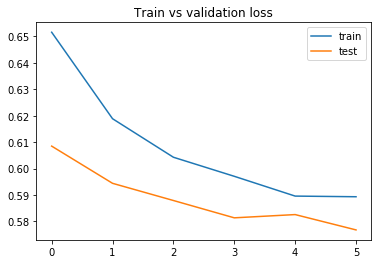

In [29]:
# plot training curve of best model
plt.plot(grid_results.train_loss_hist.values[0], label='train')
plt.plot(grid_results.val_loss_hist.values[0], label='test')
plt.title('Train vs validation loss')
plt.legend()
plt.show()

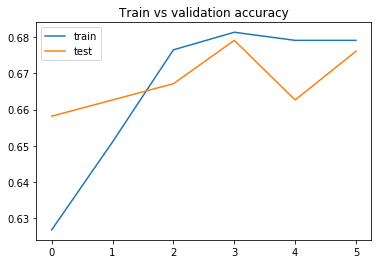

In [30]:
# train vs test accuracy
plt.plot(grid_results.train_acc_hist.values[0], label='train')
plt.plot(grid_results.val_acc_hist.values[0], label='test')
plt.title('Train vs validation accuracy')
plt.legend()
plt.show()

In [31]:
best_rating_hparams = grid_results.iloc[0,:][['n_factors' ,'n_hidden_1', 'n_hidden_2']]
best_rating_hparams

n_factors          125
n_hidden_1    [75, 30]
n_hidden_2    [75, 30]
Name: 7, dtype: object

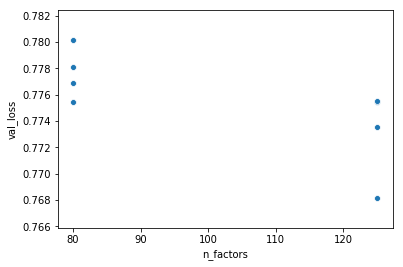

In [32]:
sns.scatterplot(x='n_factors',
                y='val_loss',
#                 hue='n_hidden_2',
#                 size='n_hidden_2',
#                 palette='Set3',
                data=grid_results)
plt.show()

## Classification report

In [33]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

### Re-train model on full dataset, with best hparams

In [34]:
# get baseline predictors for full dataset
train, _, _ = get_baseline(df, df.index, df.index)

# compile both models
model1, model2 = compile_genre_model(
    n_items = df.movieId.nunique(),
    n_users = df.userId.nunique(),
    mean_rating = df.rating.mean(), 
    n_latent=best_rating_hparams.n_factors, 
    n_hidden_1=best_rating_hparams.n_hidden_1,
    n_hidden_2=best_rating_hparams.n_hidden_2
)

# train rating model
ratings = model1.fit(
    x=[train.userId.values, train.movieId.values, train.bias.values],
    y=train.rating.values, 
    batch_size=256,
    epochs=10,
    verbose=1,
    validation_split=.2
)

# train genre model
genres = model2.fit(
    movies.movieId.values, movies.Drama.values,
    batch_size=64, 
    epochs=7,
    validation_split=.2)

Train on 800167 samples, validate on 200042 samples
Epoch 1/10
800167/800167 [==============================] - 53s 66us/sample - loss: 0.8196 - val_loss: 0.8703
Epoch 2/10
800167/800167 [==============================] - 55s 69us/sample - loss: 0.7776 - val_loss: 0.8734
Epoch 3/10
800167/800167 [==============================] - 58s 72us/sample - loss: 0.7564 - val_loss: 0.8744
Epoch 4/10
800167/800167 [==============================] - 64s 79us/sample - loss: 0.7427 - val_loss: 0.8777
Epoch 5/10
800167/800167 [==============================] - 64s 79us/sample - loss: 0.7301 - val_loss: 0.8787
Epoch 6/10
800167/800167 [==============================] - 63s 79us/sample - loss: 0.7164 - val_loss: 0.8832
Epoch 7/10
800167/800167 [==============================] - 64s 80us/sample - loss: 0.7048 - val_loss: 0.8892
Epoch 8/10
800167/800167 [==============================] - 67s 83us/sample - loss: 0.6938 - val_loss: 0.8899
Epoch 9/10
800167/800167 [==============================] - 66s 82us

In [21]:
model1.summary()

W1011 14:07:04.437685  9640 training.py:2090] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


Model: "model_80"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_121 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_122 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_80 (Embedding)        (None, 1, 125)       463250      input_121[0][0]                  
__________________________________________________________________________________________________
embedding_81 (Embedding)        (None, 1, 125)       755000      input_122[0][0]                  
___________________________________________________________________________________________

In [22]:
model2.summary()

Model: "model_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_121 (InputLayer)       [(None, 1)]               0         
_________________________________________________________________
embedding_80 (Embedding)     (None, 1, 125)            463250    
_________________________________________________________________
flatten_80 (Flatten)         (None, 125)               0         
_________________________________________________________________
dense_243 (Dense)            (None, 75)                9450      
_________________________________________________________________
leaky_re_lu_162 (LeakyReLU)  (None, 75)                0         
_________________________________________________________________
dropout_162 (Dropout)        (None, 75)                0         
_________________________________________________________________
dense_244 (Dense)            (None, 30)                228

### Evaluate on test set

In [23]:
X_test = movies_holdout.movieId.values
y_test = movies_holdout.Drama.values
y_score = pd.DataFrame(model2.predict(X_test))
y_pred = y_score.round().astype('int')

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.77      0.75       227
           1       0.60      0.53      0.56       144

    accuracy                           0.68       371
   macro avg       0.66      0.65      0.66       371
weighted avg       0.67      0.68      0.68       371



In [25]:
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1
0,175,52
1,67,77
